#Rules for Easy21
1. Each draw of the deck results in a value between 1 to 10, Prob(red, -) = 1/3, Prob(black, +) = 2/3;
2. At the start of the game, player and dealer draw one black card;
3. Each time, player may either stick or hit.

*   If player stick, the player recieves no future cards;
*   If player hit, the player draw another card.

4. If the player's sum exceeeds 21, or becomes less than 1, then the player "bust" and get reward -1
5. If the player stick, the dealer starts taking turns.

*   If the dealer goes bust, then the player win, and get reward +!
*   If the dealer get 17 or greater, the player either win(reward +1), lose(reward -1), or draw (reward 0).







##1. Implementation of Easy21

1. Write a function `step()`:  takes state and action as input, and return the next state and reward

Inputs:

*   state
*   action

return


*   state (next)
*   reward

`setp(state: [dealer_first_card, player_first_card], action: Action) -> state, reward`

There is no discounting factor and calling step with a stick action will paly out the dealer's card and return the final reward and terminal state.

In [38]:
from enum import Enum
from random import randint


class Action(Enum):
    STICK = 1
    HIT = 2


class Reward(Enum):
    DRAW = 0
    WIN = 1
    LOOSE = -1


class State:
    def __init__(self, dealer_first_card, player_sum, isFinished=False):
        self.dealer_first_card = int(dealer_first_card)
        self.player_sum = int(player_sum)
        self.isFinished = isFinished
        self.string = "Dealer Final Sum is {}, Player Final Sum is {}\n".format(self.dealer_first_card,
                                                                                  self.player_sum) if self.isFinished else "Dealer First Card is Black {}, Player current Sum is {}\n".format(self.dealer_first_card,
                                                                                  self.player_sum)
    def deepCopy(self):
        return State(self.dealer_first_card, self.player_sum, self.isFinished)

    def __str__(self):
        return self.string

    def __repr__(self):
        return self.__str__()

    # hash the state as an int
    def __hash__(self):
        return self.dealer_first_card * 100 + self.player_sum

    def tuple(self):
      return (self.dealer_first_card, self.player_sum)


def draw_black_card():
    return randint(1, 10)


def draw_card():
    p = [1, 1, -1]
    result = p[randint(0, 2)] * randint(1, 10)
    return result


class Easy21:

    def __init__(self, display = False) -> None:
       self.display = display # set this to be True if you want to display all dealer's cards when player stick

    # If the dealer sum is less than 17, and not brust, draw another card
    # after dealer's action is done, set the isFinished to be True
    def _dealer_hits(self, state: State):
        dealer_cards = [state.dealer_first_card]
        while 0 < sum(dealer_cards) < 17:
            next_card = draw_card()
            dealer_cards.append(next_card)

        # display the dealer's card, this is a requirement from the assignment, but is not necessary for training.
        if self.display:
          print("\n")
          print("The dealer's cards are listed below (+ are black cards, - are red cards)")
          print(dealer_cards)
        # if the dealer sum is greater or equal to 17 or less than 1, finished
        return State(sum(dealer_cards), state.player_sum, True)

    def _player_hits(self, state: State):
        next_card = draw_card()
        player_sum = state.player_sum + next_card
        if player_sum < 1 or player_sum > 21:  # player should stop action at 21
            return State(state.dealer_first_card, player_sum, True)
        else:
            return State(state.dealer_first_card, player_sum, False)

    def _calculate_reward(self, state: State):
        # if the game is not finished, then this is a draw
        if not state.isFinished:
            return Reward.DRAW

        # if the game is finished, find out the final reward
        if state.isFinished:
            dealer_sum = state.dealer_first_card
        if state.player_sum > 21 or state.player_sum < 1:
            return Reward.LOOSE
        elif dealer_sum > 21 or dealer_sum < 1:
            return Reward.WIN
        elif state.player_sum == dealer_sum:
            return Reward.DRAW
        elif state.player_sum > dealer_sum:
            return Reward.WIN
        elif state.player_sum < dealer_sum:
            return Reward.LOOSE
        else:
            raise Exception(
                "The calculation for dealer sum ({}) and player sum ({}) is out of bound.".format(self.dealer_sum,
                                                                                                  state.player_sum))

    def step(self, state: State, action: Action):

        # if player stick, dealer need to hit
        if action is Action.STICK:
            next_state = self._dealer_hits(state)
        # if player hit, move to next state
        else:
            next_state = self._player_hits(state)

        reward = self._calculate_reward(next_state)
        return next_state, reward

Unit test for Easy21 Implementation

In [44]:
# unit test case
import unittest


class TestEasy21(unittest.TestCase):

    def test_drawn(self):
        # dealer get 21, and player get 21, stick should return drawn
        easy21 = Easy21(display=True)
        state1 = State(21, 21)
        expected = Reward.DRAW
        actual = easy21.step(state1, Action.STICK)[1]
        self.assertEqual(actual, expected)

    def test_win(self):
        # dealer get 17 or higher, player got 21, stick should return win
        easy21 = Easy21(display=True)
        state2 = State(17, 21)
        state3 = State(20, 21)
        expected = Reward.WIN
        actual1 = easy21.step(state2, Action.STICK)[1]
        actual2 = easy21.step(state3, Action.STICK)[1]
        self.assertEqual(actual1, expected)
        self.assertEqual(actual2, expected)

    # this shows how to display all dealer's cards when player stick.
    def test_dealer_cards_can_be_displayed(self):
        easy21 = Easy21(display=True)
        state = State(5, 8)
        print("\n This should play more than one card that dealer has")
        easy21.step(state, Action.STICK)

unittest.main(argv=[''], verbosity=2, exit=False)

test_dealer_cards_can_be_displayed (__main__.TestEasy21) ... ok
test_drawn (__main__.TestEasy21) ... ok
test_win (__main__.TestEasy21) ... 


 This should play more than one card that dealer has


The dealer's cards are listed below (+ are black cards, - are red cards)
[5, 2, 5, 6]


The dealer's cards are listed below (+ are black cards, - are red cards)
[21]


The dealer's cards are listed below (+ are black cards, - are red cards)
[17]


The dealer's cards are listed below (+ are black cards, - are red cards)
[20]


ok

----------------------------------------------------------------------
Ran 3 tests in 0.013s

OK


##2. Monte-Carlo Control in Easy21
### ---- makeing decisions without a model of how the world works (what card dealder is going to draw)

Let $N(s)$ is the number of times that the state S has been visited, 


Let $N(s, a)$ be the number of times that action a has been selected from state 


Let step-size $t= \frac{1}{N(S_t, a_t)}$

In [22]:
from collections import defaultdict
from random import uniform
from datetime import datetime


class MonteCarloSampler:

    def __init__(self, N0 = 100) -> None:
        self.N = defaultdict(int)
        self.Q = defaultdict(int)
        self.N0 = N0

    # the 1st element should have prob eta/2, and the second element should have prob 1 - eta/2
    def _argmaxq(self, state):
        # todo: action should be part of the easy21 env
        if self.Q[(state.tuple(), Action.HIT)] > self.Q[(state.tuple(), Action.STICK)]:
          return [Action.HIT, Action.STICK]
        else:
          return [Action.STICK, Action.HIT]

    def _explore_vs_exploit(self, a, p_a, b):
      # print(">> Best action is {}, with prob {}".format(a, p_a))
      # print(uniform(0,100))
      return a if uniform(0,100) < p_a else b 

    # Dummy policy always hit
    def _policy(self, state: State, force_output = None):
      # return Action.HIT
      # DEALER POLICY
      # if state.player_sum >= 17:
      #   return Action.STICK
      # else:
      #   return Action.HIT

        # if force_output:
        #   return force_output

      eta = self.N0/(self.N0 + self.N[state.tuple(), Action.HIT] + self.N[state.tuple(), Action.STICK])*100
      best_action, other_action = self._argmaxq(state)
      return self._explore_vs_exploit(best_action, 100 - (eta/2), other_action)

    # generate a sample from MC, and save all the states, actions, reward pairs
    def _generate_episode(self, dealer_first_card=None, player_first_card=None):
        if not dealer_first_card and not player_first_card:
            state = State(draw_black_card(), draw_black_card())
        else:
            state = State(dealer_first_card, player_first_card)
        easy21 = Easy21()
        states = [state.tuple()]
        actions = []
        rewards = []

        while not state.isFinished:
            action = self._policy(state)
            state, reward = easy21.step(state, action)
            actions.append(action)
            rewards.append(reward)
            states.append(state.tuple())
            # if state.player_sum == 21:
            #   print("Found a player sum is 21 :", state.tuple())
            #   print("Reward is ", reward)
        return states, actions, rewards

    def train(self, max_epoch = 3):
      progress_bar = [_*max_epoch//10 for _ in range(10)]

      cnter = 0
      current_epoch = 0

      while current_epoch < max_epoch:

        if current_epoch in progress_bar:
          now = datetime.now()
          current_time = now.strftime("%H:%M:%S")
          print(" >> {}% has been finished out of {} epoch at {}".format(cnter, max_epoch, current_time))
          cnter += 10
        
        current_epoch +=1
        
        states, actions, rewards = self._generate_episode()
        # print(states)
        # print(actions)
        # print(rewards)
        G = rewards[-1].value # this is the trick that only the last step return the reward, since gamma is 1, so all the G equals the final reward
        sumG = sum([ _.value for _ in rewards])
        for i in range(len(actions)):
          state_action_pair = (states[i], actions[i])
          # if state_action_pair[0][1] == 21:
          #   print("============================================================")
          #   print(" train with 21: ", state_action_pair[0], " and reward is ", G)
          # else:
          #   print(">> ", state_action_pair[0])
          self.N[state_action_pair] += 1
          self.Q[state_action_pair] += 1/self.N[state_action_pair]*(G - self.Q[state_action_pair])
          # print("G is ", G, state_action_pair[0])
          # print(self.Q[state_action_pair] )
     
# 5000000 can produce good result     
mc = MonteCarloSampler()
mc.train(5000000)

 >> 0% has been finished out of 5000000 epoch at 18:50:25
 >> 10% has been finished out of 5000000 epoch at 18:50:41
 >> 20% has been finished out of 5000000 epoch at 18:50:56
 >> 30% has been finished out of 5000000 epoch at 18:51:10
 >> 40% has been finished out of 5000000 epoch at 18:51:26
 >> 50% has been finished out of 5000000 epoch at 18:51:41
 >> 60% has been finished out of 5000000 epoch at 18:51:55
 >> 70% has been finished out of 5000000 epoch at 18:52:11
 >> 80% has been finished out of 5000000 epoch at 18:52:26
 >> 90% has been finished out of 5000000 epoch at 18:52:40


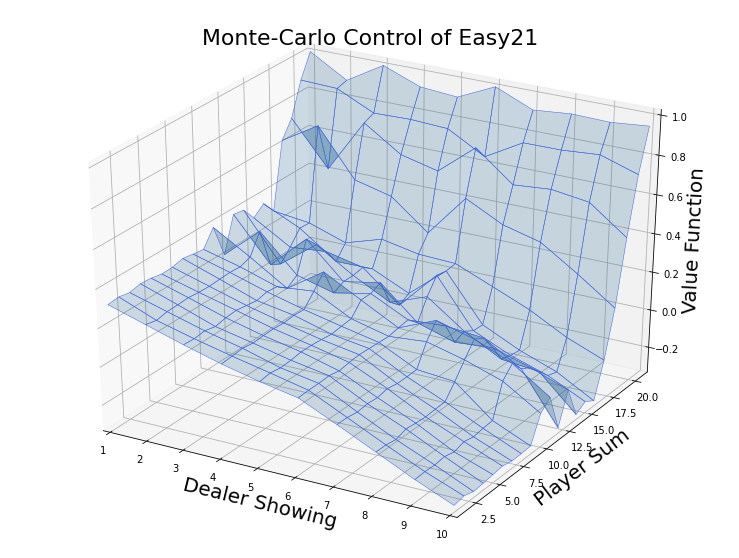

In [34]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 20
import numpy as np
import math

ax = plt.figure().add_subplot(projection='3d')

x = np.linspace(1, 10, 10)
y = np.linspace(1, 21, 21)
Z = []

for i in y:
  row = []
  for j in x:
    row.append(max(mc.Q[((j, i), Action.HIT)], mc.Q[((j, i), Action.STICK)]))
  Z.append(row)

X, Y = np.meshgrid(x, y)
Z = np.array(Z)

# Plot the 3D surface
ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=1, cstride=1,
                alpha=0.2)

ax.set(xlim=(1, 10), ylim=(1, 21), 
       xlabel='Dealer Showing', ylabel='Player Sum', zlabel='Value Function')

ax.set_title('Monte-Carlo Control of Easy21', fontsize=22)
ax.figure.set_size_inches(13, 10)
plt.show()

##3. TD Learning in Easy21

Implement SARSA and Q-Learning in Easy21. 


*   Initialise the value function to zero
*   Use the same step-[size and exploration schedule as in the previous section
*   Stop after 1000 episodes and report the mean-square error over all the states s and action a
*   Compare the true value of q computed in the previous section with the estimated values q computed by SARSA and Q learning
*   Plot the learning curves asnd mean-squared-error against episode number



### 3.1 SARSA

In [23]:
from copy import copy

class SARSA:
    def __init__(self, mc=None) -> None:
        self.N0 = 100
        self.mc = mc # the monte carlo model used to calculate mean square error
        self.mse = []
        self.Q1k = None
        self.Q = defaultdict(int)  # keys are ((#dealer, #player), action)
        self.N = defaultdict(int)  # keys are (#dealer, #player)
        self.A = defaultdict(int)  # keys are ((#dealer, #player), action) counter for calculate learning rate
        self.x = np.linspace(1, 10, 10)
        self.y = np.linspace(1, 21, 21)

    def _argmaxq(self, state):
        # todo: action should be part of the easy21 env
        if self.Q[(state.tuple(), Action.HIT)] > self.Q[(state.tuple(), Action.STICK)]:
            return [Action.HIT, Action.STICK]
        else:
            return [Action.STICK, Action.HIT]

    def _explore_vs_exploit(self, a, p_a, b):
        return a if uniform(0, 100) < p_a else b

        # Dummy policy always hit

    def _policy(self, state: State):
        eta = self.N0 / (self.N0 + self.N[state.tuple()]) * 100
        best_action, other_action = self._argmaxq(state)
        return self._explore_vs_exploit(best_action, 100 - (eta / 2), other_action)

    def calculate_mean_square_error(self):
        error = 0
        for i in self.y:
          for j in self.x:
            for e in [((j, i), Action.HIT), ((j, i), Action.STICK)]:
              error += (self.mc.Q[e] - self.Q[e])*(self.mc.Q[e] - self.Q[e])
        self.mse.append(error)

    def train(self):
        easy21 = Easy21()
        state = State(draw_black_card(), draw_black_card())
        action = self._policy(state)
        cnt = 1
        
        while cnt <= 50000:
            while not state.isFinished:
                self.A[(state.tuple(), action)] += 1
                self.N[state.tuple()] += 1

                next_state, reward = easy21.step(state, action)
                next_action = self._policy(next_state)
                self.Q[(state.tuple(), action)] += 1 / self.A[(state.tuple(), action)] * (
                        reward.value + self.Q[(next_state.tuple(), next_action)] - self.Q[(state.tuple(), action)])
                if cnt == 1000:
                  self.Q1k = copy(self.Q)
                

                cnt += 1
                state = next_state
                action = next_action
                if self.mc:
                  self.calculate_mean_square_error()
            
            # if the current state is finished, need to generate a new start
            state = State(draw_black_card(), draw_black_card())
            action = self._policy(state)

sarsa = SARSA(mc)
sarsa.train()

In [10]:
len(sarsa.mse)

50000

For SARSA: Make a plot of the Q space after training, and plot error vs episode

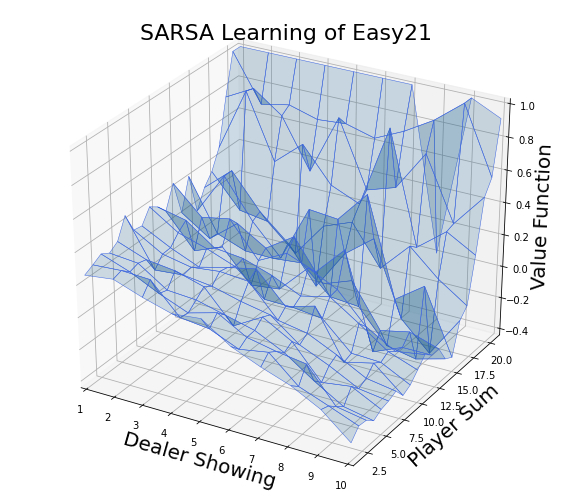

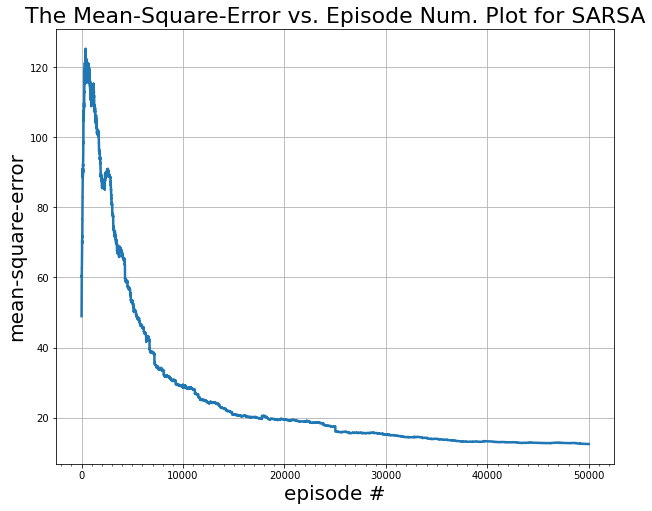

In [24]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
ax = plt.figure().add_subplot(projection='3d')

x = np.linspace(1, 10, 10)
y = np.linspace(1, 21, 21)
Z = []

for i in y:
  row = []
  for j in x:
    row.append(max(sarsa.Q[((j, i), Action.HIT)], sarsa.Q[((j, i), Action.STICK)]))
  Z.append(row)

X, Y = np.meshgrid(x, y)
Z = np.array(Z)

# Plot the 3D surface
ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=1, cstride=1,
                alpha=0.2)

ax.set(xlim=(1, 10), ylim=(1, 21), 
       xlabel='Dealer Showing', ylabel='Player Sum', zlabel='Value Function')
ax.set_title('SARSA Learning of Easy21', fontsize=22)
ax.figure.set_size_inches(10, 9)
plt.show()
# Data for plotting
# x = np.arange(1, 10001, 1)
# sarsa_data = sarsa.mse[:10000]

x = np.arange(1, 50001, 1)
sarsa_data = sarsa.mse

fig, ax = plt.subplots()
ax.plot(x, sarsa_data)

ax.set(xlabel='episode #', ylabel='mean-square-error')
ax.set_title('The Mean-Square-Error vs. Episode Num. Plot for SARSA', fontsize=22)
ax.grid()
ax.figure.set_size_inches(10, 8)
ax.xaxis.set_minor_locator(MultipleLocator(1000))
# fig.savefig("test.png")
plt.show()

###3.2 Q_Learning (off policy learning)

In [29]:
class QLEARNING:
    def __init__(self, mc=None) -> None:
        self.N0 = 100
        self.mc = mc # the monte carlo model used to calculate mean square error
        self.mse = []
        self.Q1k = None
        self.Q = defaultdict(int)  # keys are ((#dealer, #player), action)
        self.N = defaultdict(int)  # keys are (#dealer, #player)
        self.A = defaultdict(int)  # keys are ((#dealer, #player), action) counter for calculate learning rate
        self.x = np.linspace(1, 10, 10)
        self.y = np.linspace(1, 21, 21)

    def _argmaxq(self, state):
        # todo: action should be part of the easy21 env
        if self.Q[(state.tuple(), Action.HIT)] > self.Q[(state.tuple(), Action.STICK)]:
            return [Action.HIT, Action.STICK]
        else:
            return [Action.STICK, Action.HIT]

    def _explore_vs_exploit(self, a, p_a, b):
        return a if uniform(0, 100) < p_a else b

        # Dummy policy always hit

    def _policy(self, state: State):
        eta = self.N0 / (self.N0 + self.N[state.tuple()]) * 100
        best_action, other_action = self._argmaxq(state)
        return self._explore_vs_exploit(best_action, 100 - (eta / 2), other_action)

    def calculate_mean_square_error(self):
        error = 0
        for i in self.y:
          for j in self.x:
            for e in [((j, i), Action.HIT), ((j, i), Action.STICK)]:
              error += (self.mc.Q[e] - self.Q[e])*(self.mc.Q[e] - self.Q[e])
        self.mse.append(error)

    def train(self):
        easy21 = Easy21()
        state = State(draw_black_card(), draw_black_card())
        action = self._policy(state)
        cnt = 1
        
        while cnt <= 50000:
            while not state.isFinished:
                self.A[(state.tuple(), action)] += 1
                self.N[state.tuple()] += 1

                next_state, reward = easy21.step(state, action)
                
                self.Q[(state.tuple(), action)] += 1 / self.A[(state.tuple(), action)] * (
                        reward.value + max(self.Q[(next_state.tuple(), Action.HIT)], self.Q[(next_state.tuple(), Action.STICK)])- self.Q[(state.tuple(), action)])
                if cnt == 1000:
                  self.Q1k = copy(self.Q)
                
                cnt += 1
                state = next_state
                action = self._policy(next_state)
                if self.mc:
                  self.calculate_mean_square_error()
            
            # if the current state is finished, need to generate a new start
            state = State(draw_black_card(), draw_black_card())
            action = self._policy(state)

qlearning = QLEARNING(mc)
qlearning.train()

In [13]:
len(qlearning.mse)

50000

Plot for Q-Learning

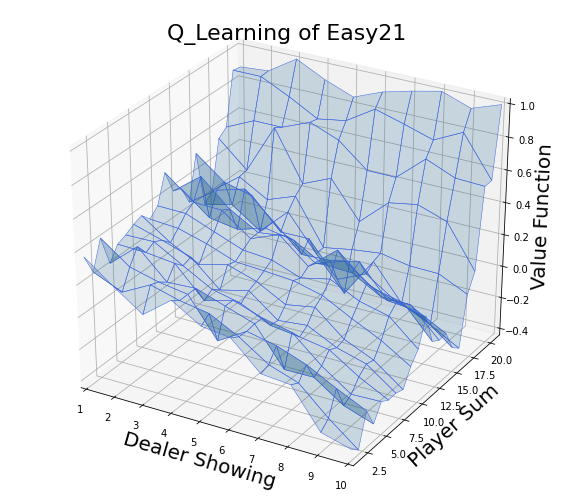

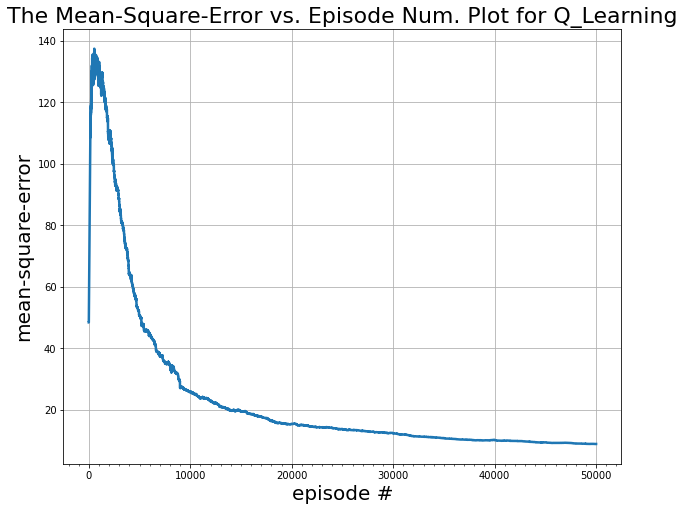

In [30]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
ax = plt.figure().add_subplot(projection='3d')

x = np.linspace(1, 10, 10)
y = np.linspace(1, 21, 21)
Z = []

for i in y:
  row = []
  for j in x:
    row.append(max(qlearning.Q[((j, i), Action.HIT)], qlearning.Q[((j, i), Action.STICK)]))
  Z.append(row)

X, Y = np.meshgrid(x, y)
Z = np.array(Z)

# Plot the 3D surface
ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=1, cstride=1,
                alpha=0.2)

ax.set(xlim=(1, 10), ylim=(1, 21), 
       xlabel='Dealer Showing', ylabel='Player Sum', zlabel='Value Function')
ax.set_title('Q_Learning of Easy21', fontsize=22)
ax.figure.set_size_inches(10, 9)
plt.show()
# Data for plotting

x = np.arange(1, 50001, 1)
qlearning_data = qlearning.mse

fig, ax = plt.subplots()
ax.plot(x, qlearning_data)

ax.set(xlabel='episode #', ylabel='mean-square-error',
       title='The Mean-Square-Error vs. Episode Num. Plot for Q_Learning')
ax.set_title('The Mean-Square-Error vs. Episode Num. Plot for Q_Learning', fontsize=22)
ax.grid()
ax.figure.set_size_inches(10, 8)
ax.xaxis.set_minor_locator(MultipleLocator(1000))
# fig.savefig("test.png")
plt.show()

Compare SARSA and Q_Learning

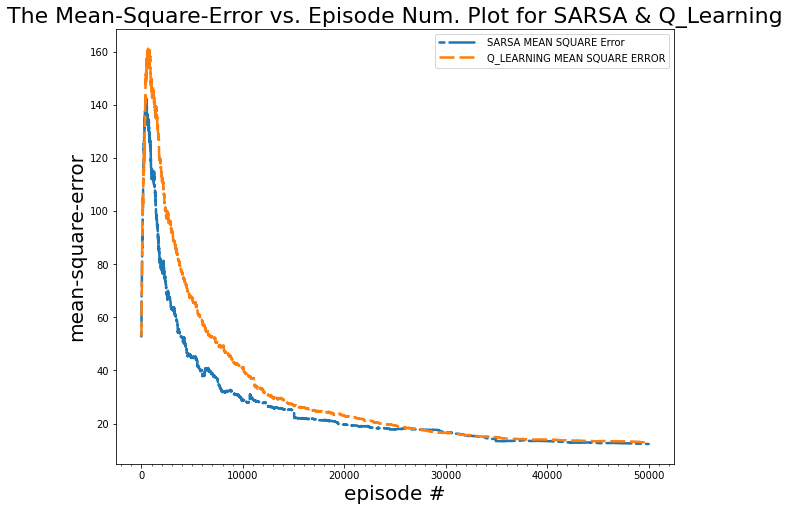

In [15]:
x = np.arange(1, 50001, 1)
sarsa_data = sarsa.mse
qlearning_data = qlearning.mse


plt.rc('lines', linewidth=2.5)
fig, ax = plt.subplots()

# Using set_dashes() and set_capstyle() to modify dashing of an existing line.
line1, = ax.plot(x, sarsa_data, label='SARSA MEAN SQUARE Error')
line1.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break.
line1.set_dash_capstyle('round')


# Using plot(..., dashes=...) to set the dashing when creating a line.
x = np.arange(1, 50001, 1)
line2, = ax.plot(x, qlearning_data, dashes=[6, 2], label='Q_LEARNING MEAN SQUARE ERROR')

ax.set(xlabel='episode #', ylabel='mean-square-error')
ax.set_title('The Mean-Square-Error vs. Episode Num. Plot for SARSA & Q_Learning', fontsize=22)
ax.figure.set_size_inches(10, 8)
ax.xaxis.set_minor_locator(MultipleLocator(1000))

ax.legend(handlelength=4)
plt.show()

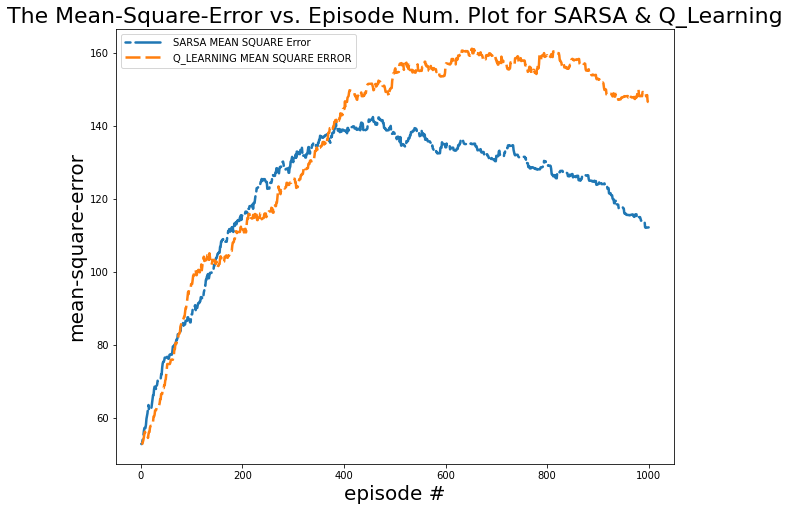

At epoch 1000, the mean square error for SARSA is 114.7124708808326
At epoch 1000, the mean square error for Q_Learning is 146.56684338626397


In [21]:
x = np.arange(1, 1001, 1)
sarsa_data = sarsa.mse[:1000]
qlearning_data = qlearning.mse[:1000]


plt.rc('lines', linewidth=2.5)
fig, ax = plt.subplots()

# Using set_dashes() and set_capstyle() to modify dashing of an existing line.
line1, = ax.plot(x, sarsa_data, label='SARSA MEAN SQUARE Error')
line1.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break.
line1.set_dash_capstyle('round')


# Using plot(..., dashes=...) to set the dashing when creating a line.
# x = np.arange(1, 50001, 1)
line2, = ax.plot(x, qlearning_data, dashes=[6, 2], label='Q_LEARNING MEAN SQUARE ERROR')

ax.set(xlabel='episode #', ylabel='mean-square-error')
ax.set_title('The Mean-Square-Error vs. Episode Num. Plot for SARSA & Q_Learning', fontsize=22)
ax.figure.set_size_inches(10, 8)
ax.xaxis.set_minor_locator(MultipleLocator(1000))

ax.legend(handlelength=4)
plt.show()
print("At epoch 1000, the mean square error for SARSA is {}".format(sarsa.mse[1000]))
print("At epoch 1000, the mean square error for Q_Learning is {}".format(qlearning.mse[1000]))

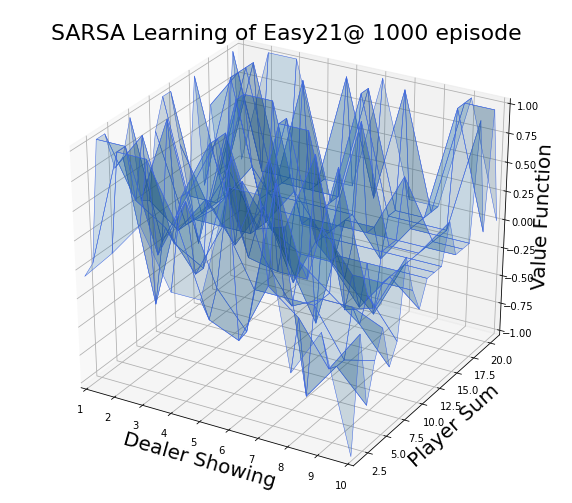

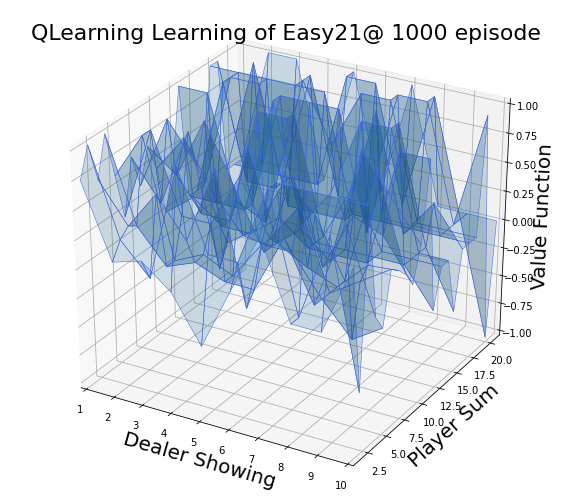

In [32]:
ax = plt.figure().add_subplot(projection='3d')

x = np.linspace(1, 10, 10)
y = np.linspace(1, 21, 21)
Z = []

for i in y:
  row = []
  for j in x:
    row.append(max(sarsa.Q1k[((j, i), Action.HIT)], sarsa.Q1k[((j, i), Action.STICK)]))
  Z.append(row)

X, Y = np.meshgrid(x, y)
Z = np.array(Z)

# Plot the 3D surface
ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=1, cstride=1,
                alpha=0.2)

ax.set(xlim=(1, 10), ylim=(1, 21), 
       xlabel='Dealer Showing', ylabel='Player Sum', zlabel='Value Function')
ax.set_title('SARSA Learning of Easy21@ 1000 episode', fontsize=22)
ax.figure.set_size_inches(10, 9)
plt.show()

# another plot
ax = plt.figure().add_subplot(projection='3d')

x = np.linspace(1, 10, 10)
y = np.linspace(1, 21, 21)
Z = []

for i in y:
  row = []
  for j in x:
    row.append(max(qlearning.Q1k[((j, i), Action.HIT)], qlearning.Q1k[((j, i), Action.STICK)]))
  Z.append(row)

X, Y = np.meshgrid(x, y)
Z = np.array(Z)

# Plot the 3D surface
ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=1, cstride=1,
                alpha=0.2)

ax.set(xlim=(1, 10), ylim=(1, 21), 
       xlabel='Dealer Showing', ylabel='Player Sum', zlabel='Value Function')
ax.set_title('QLearning Learning of Easy21@ 1000 episode', fontsize=22)
ax.figure.set_size_inches(10, 9)
plt.show()